In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [3]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

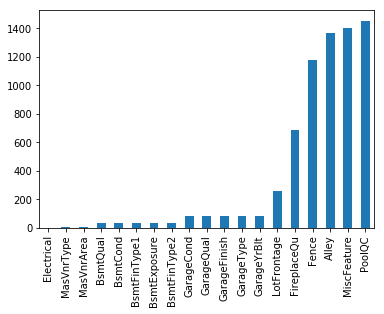

In [5]:
# missing value counts
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

# Data preprocessing

log transformation of skewed numeric features

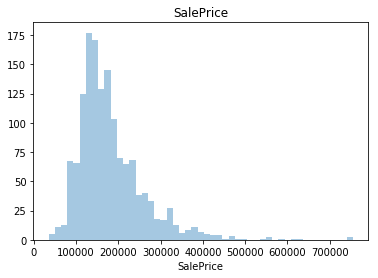

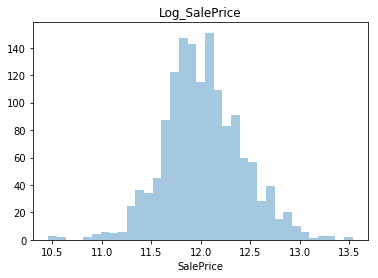

In [6]:
y = train['SalePrice']
plt.figure(1); plt.title('SalePrice')
sns.distplot(y, kde=False)
plt.figure(2); plt.title('Log_SalePrice')
sns.distplot(np.log1p(y), kde=False)
train['SalePrice'] = np.log1p(train['SalePrice'])

In [7]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], 
                      test.loc[:,'MSSubClass':'SaleCondition']))
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

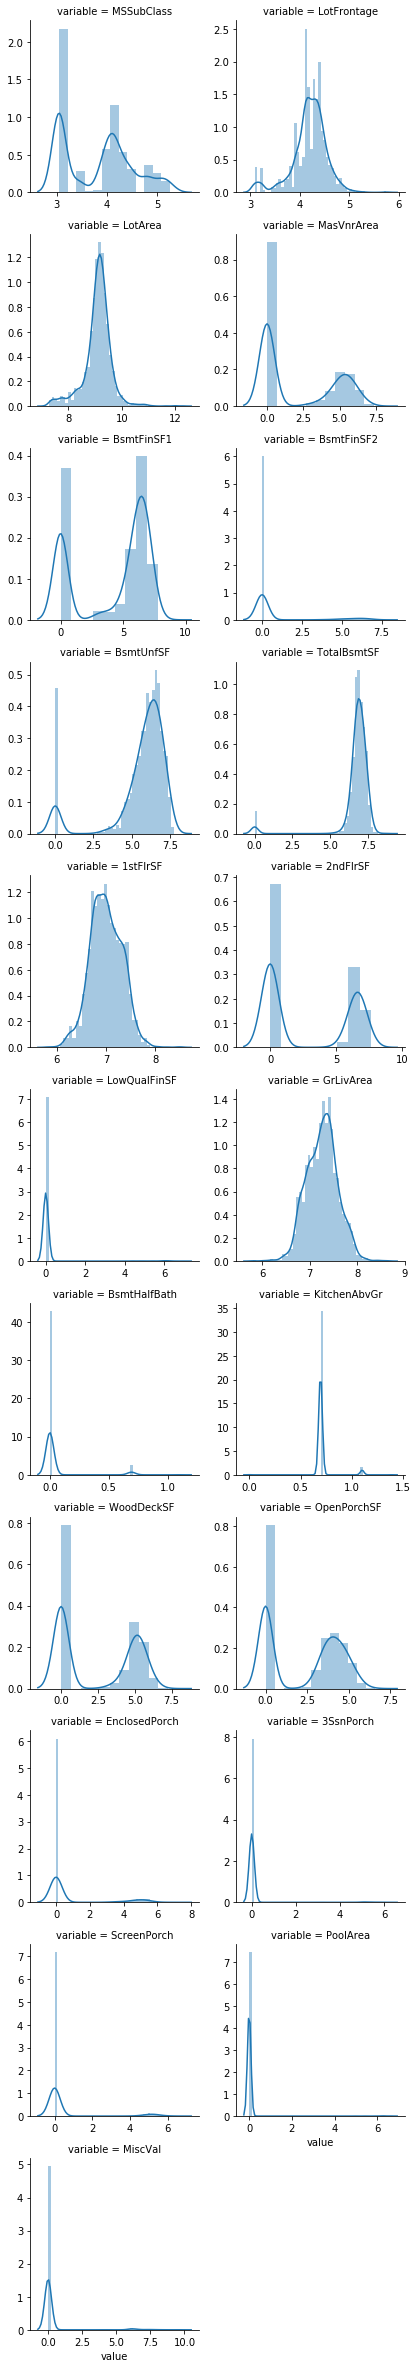

In [8]:
f = pd.melt(all_data, value_vars=skewed_feats)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

get dummies for categorical features & fill missing value with mean 

(Is there better way than filling missing value with mean?)

In [9]:
all_data = pd.get_dummies(all_data)

In [10]:
all_data = all_data.fillna(all_data.mean())

In [11]:
#creating matrices for skleaarn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train['SalePrice']

In [12]:
X_train.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    4.110874     4.189655  9.042040            7            5       2003   
1    3.044522     4.394449  9.169623            6            8       1976   
2    4.110874     4.234107  9.328212            7            5       2001   
3    4.262680     4.110874  9.164401            7            5       1915   
4    4.110874     4.442651  9.565284            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2          ...            \
0          2003    5.283204    6.561031         0.0          ...             
1          1976    0.000000    6.886532         0.0          ...             
2          2002    5.093750    6.188264         0.0          ...             
3          1970    0.000000    5.379897         0.0          ...             
4          2000    5.860786    6.486161         0.0          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 288 columns]

# models

In [19]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score

In [20]:
def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))

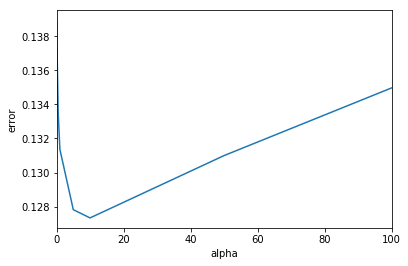

In [21]:
alphas = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index=alphas)

cv_ridge.plot()
plt.xlabel('alpha')
plt.ylabel('error')

In [22]:
cv_ridge.min()

0.12733734668670763

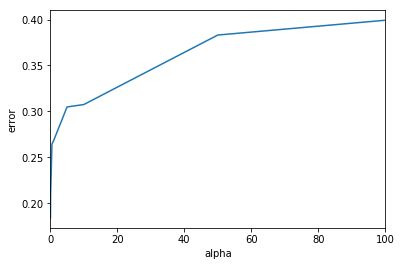

In [23]:
cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index=alphas)

cv_lasso.plot()
plt.xlabel('alpha')
plt.ylabel('error')

In [24]:
cv_lasso.min()

0.18403762011012678

since lasso model has smaller error, we will choose lasso model.

In [25]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12314421090977448

In [26]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

print('Lasso picked %d features and eliminated other %d features' %(coef[coef!=0].count(), coef[coef==0].count()))

Lasso picked 111 features and eliminated other 177 features


In [27]:
imp_coef = pd.concat((coef.sort_values()[:10],
                      coef.sort_values()[-10:]))

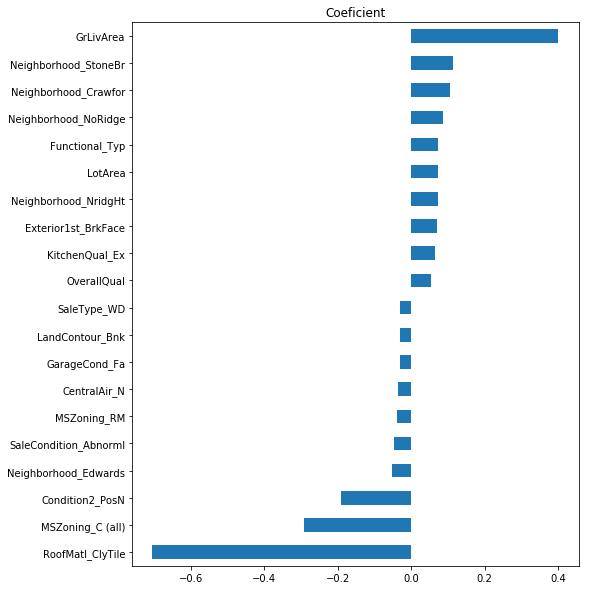

In [28]:
imp_coef.plot(kind='barh', figsize=(8,10))
plt.title('Coeficient')

In [51]:
RoofandPrice = pd.DataFrame({'Roof':X_train['RoofMatl_ClyTile'], 'Price':y})

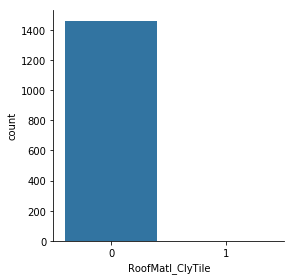

In [53]:
sns.factorplot(x='RoofMatl_ClyTile', data=X_train, kind='count')

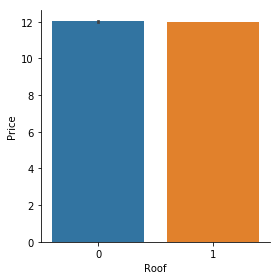

In [52]:
sns.factorplot(x='Roof', y='Price', data=RoofandPrice, kind='bar')

The most important features are GrLivArea and neighborhood. But some of the negative features don't make sense. 
Next we will see residual graph.

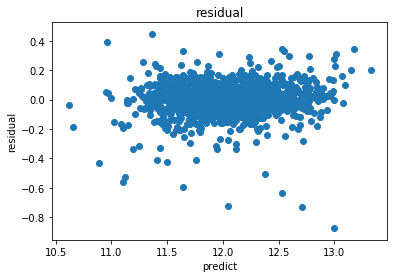

In [33]:
lasso_pred = model_lasso.predict(X_train)
residual = y - lasso_pred
plt.title('residual')
plt.xlabel('predict')
plt.ylabel('residual')
plt.scatter(x=lasso_pred, y=residual)
plt.figure(figsize=(5,5))

# Adding an XGBoost model

In [34]:
import xgboost as xgb

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model= xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [36]:
model.head()

test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0       10.380138       0.007834        10.380139        0.003413
1        9.344810       0.008219         9.344813        0.003153
2        8.413089       0.008584         8.413092        0.002927
3        7.574992       0.008599         7.574618        0.002707
4        6.820292       0.008262         6.819935        0.002493

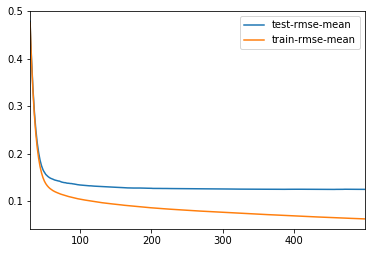

In [37]:
model.loc[30:,['test-rmse-mean','train-rmse-mean']].plot()

In [38]:
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

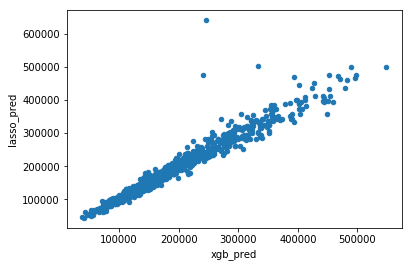

In [39]:
xgb_pred = np.expm1(model_xgb.predict(X_test))
lasso_pred = np.expm1(model_lasso.predict(X_test))
pred = pd.DataFrame({'xgb_pred' : xgb_pred, 'lasso_pred' : lasso_pred})
pred.plot(x='xgb_pred', y='lasso_pred', kind='scatter')

In [40]:
pred_final = 0.15*xgb_pred + 0.85*lasso_pred
solution = pd.DataFrame({"id":test.Id, "SalePrice":pred_final})
solution.to_csv("ridge_sol.csv", index = False)